# Tema 2 IA - ML Aplicat
### Alexandru LICURICEANU - 332CD

In [1417]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn import preprocessing

from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix

from typing import List
from copy import deepcopy

%matplotlib inline

CREDIT_RISK_TEST_PATH = './tema2_Credit_Risk/credit_risk_test.csv'
CREDIT_RISK_TRAIN_PATH = './tema2_Credit_Risk/credit_risk_train.csv'
CREDIT_RISK_FULL_PATH = './tema2_Credit_Risk/credit_risk_full.csv'

SALARY_PREDICTION_TEST_PATH = './tema2_SalaryPrediction/SalaryPrediction_test.csv'
SALARY_PREDICTION_TRAIN_PATH = './tema2_SalaryPrediction/SalaryPrediction_train.csv'
SALARY_PREDICTION_FULL_PATH = './tema2_SalaryPrediction/SalaryPrediction_full.csv'

pd.set_option('display.float_format', lambda x: '%.3f' % x)

# 1. Analiza tipului de atribute si a plajei de valori a acestora.

In [1418]:
red_circle = dict(markerfacecolor='r', marker='o', markeredgecolor='w')
blue_circle = dict(markerfacecolor='b', marker='o', markeredgecolor='w')

def print_numeric_boxplots(df: pd.DataFrame, marker: dict, semilogy=[], symlog=[]):
    numerical_columns = df.describe().columns

    _, axs = plt.subplots(1, len(numerical_columns), figsize=(20, 10))

    for i, column in enumerate(numerical_columns):
        ax = axs[i]
        ax.boxplot(df[column].dropna(), flierprops=marker)
        ax.set_title(column)

        if column in semilogy:
            ax.semilogy()

        if column in symlog:
            ax.set_yscale('symlog')

    plt.tight_layout()


def print_categorical_barplots(df: pd.DataFrame, target_attribute: str, color: str):
    categorical_columns = df.select_dtypes(exclude=['number']).notnull().columns
    categorical_columns = categorical_columns[categorical_columns != target_attribute]

    nr_rows = 2
    nr_columns = (len(categorical_columns) + nr_rows - 1) // nr_rows

    fig, axs = plt.subplots(nr_rows, nr_columns, figsize=(18, 10))
    axs = axs.flatten()

    for i, column in enumerate(categorical_columns):
        ax = axs[i]
        df[column].value_counts().plot(kind='bar', ax=ax, color=color)

    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()

### 1.1. Dataset-ul "credit_risk_full".

Numarul de atribute numerice care nu au valori lipsa:

In [1419]:
cr_df = pd.read_csv(CREDIT_RISK_FULL_PATH)
cr_df.count(numeric_only=True)

loan_rate                        9060
loan_amount                     10000
job_tenure_years                 9736
credit_history_length_years     10000
applicant_age                   10000
applicant_income                10000
loan_income_ratio               10000
credit_history_length_months    10000
dtype: int64

Valorea medie, deviatia standard a valorilor, valoarea minima, valoarea percentilelor 25%, 50%, 75%, valoarea maxima:

In [1420]:
cr_df.describe()

loan_rate  loan_amount  job_tenure_years  credit_history_length_years  \
count   9060.000    10000.000          9736.000                    10000.000   
mean      11.007     9568.038             4.786                        5.811   
std        3.266     6350.432             4.353                        4.050   
min        5.420      500.000             0.000                        2.000   
25%        7.900     5000.000             2.000                        3.000   
50%       10.990     8000.000             4.000                        4.000   
75%       13.470    12200.000             7.000                        8.000   
max       23.220    35000.000           123.000                       30.000   

       applicant_age  applicant_income  loan_income_ratio  \
count      10000.000         10000.000          10000.000   
mean          27.745         65734.211              0.170   
std            6.360         56944.387              0.107   
min           20.000          4200.000              0.000   
25%           23.000         38595.000              0.090   
50%           26.000         55000.000              0.150   
75%           30.000         78997.000              0.230   
max          123.000       2039784.000              0.760   

       credit_history_length_months  
count                     10000.000  
mean                         75.761  
std                          48.677  
min                          25.000  
25%                          41.000  
50%                          57.000  
75%                         102.000  
max                         369.000

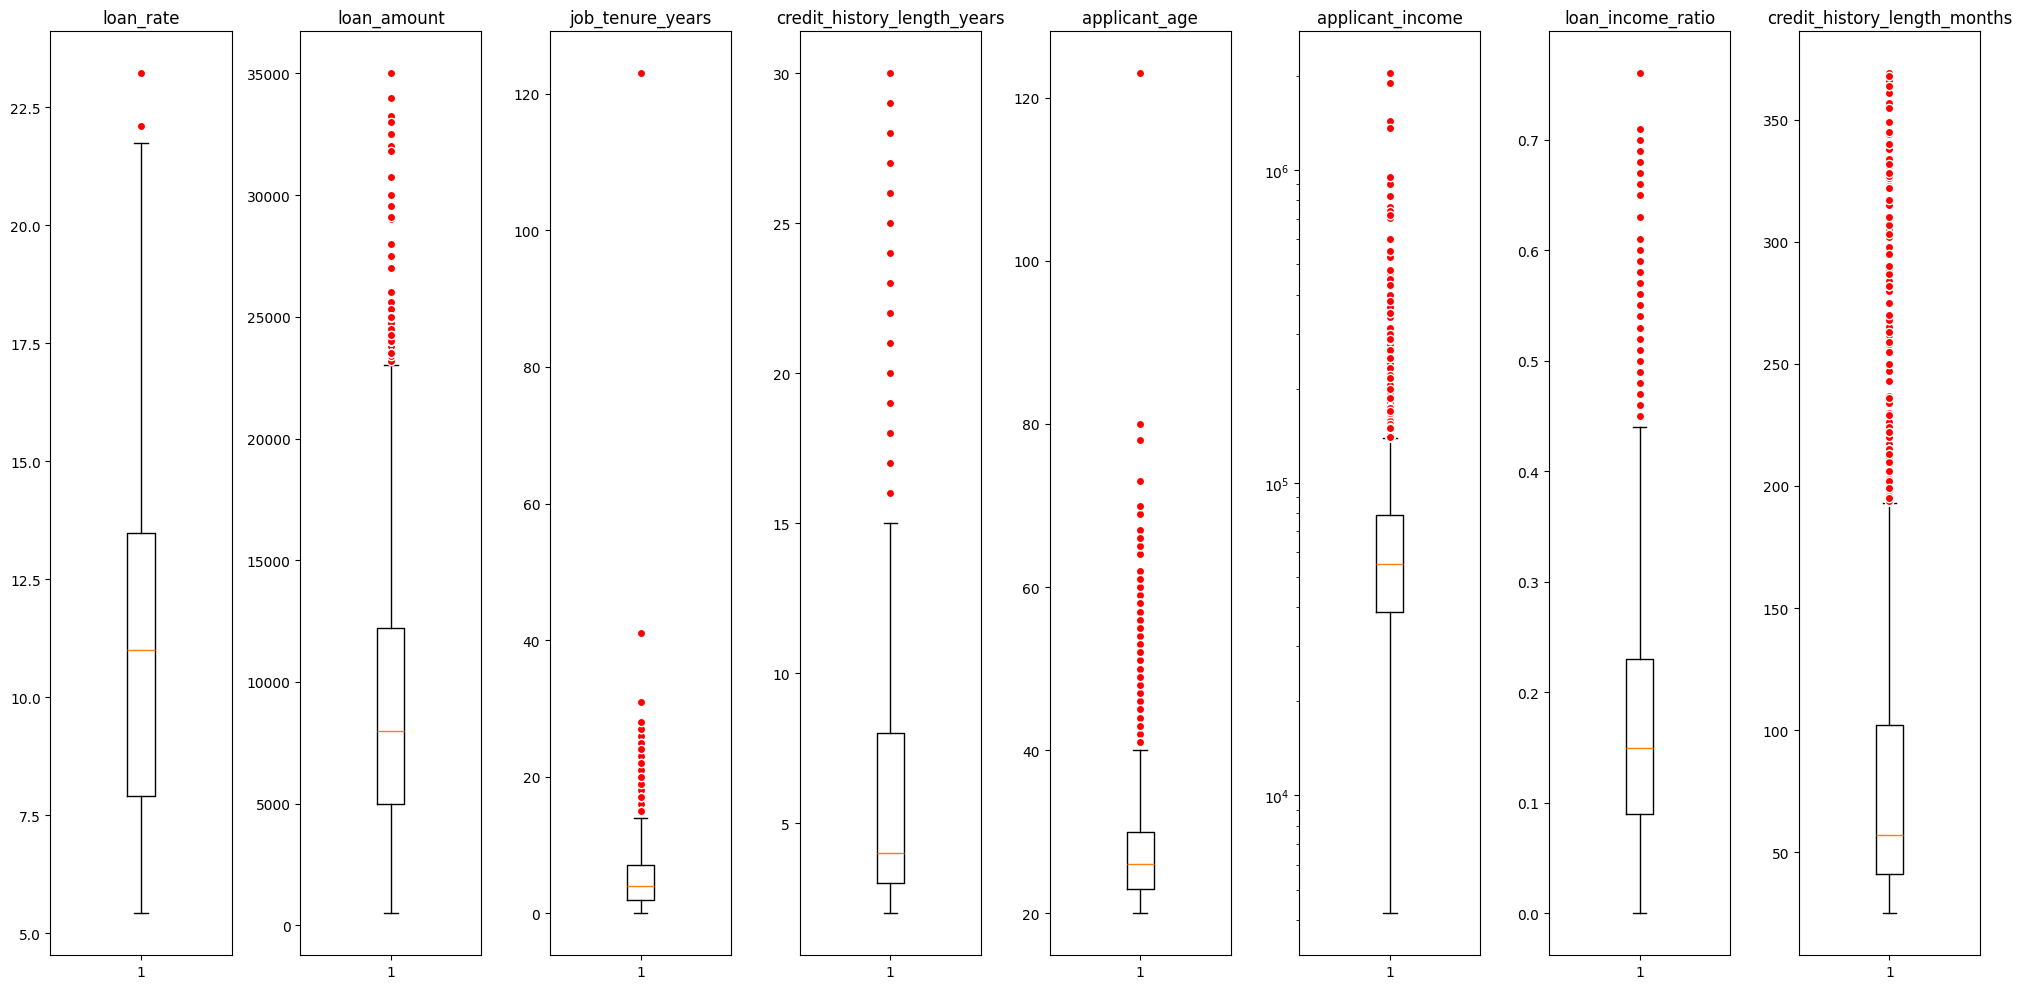

In [1421]:
print_numeric_boxplots(cr_df, red_circle, ['applicant_income'])

Numarul de atribute discrete care nu au valori lipsa:

In [1422]:
cr_df.select_dtypes(exclude=['number']).notnull().sum()

residential_status               10000
loan_purpose                     10000
loan_approval_status             10000
loan_rating                      10000
credit_history_default_status    10000
stability_rating                 10000
dtype: int64

Numarul de valori unice:

In [1423]:
cr_df.select_dtypes(exclude=['number']).nunique()

residential_status               4
loan_purpose                     6
loan_approval_status             2
loan_rating                      7
credit_history_default_status    2
stability_rating                 4
dtype: int64

Distributia atributelor discrete:

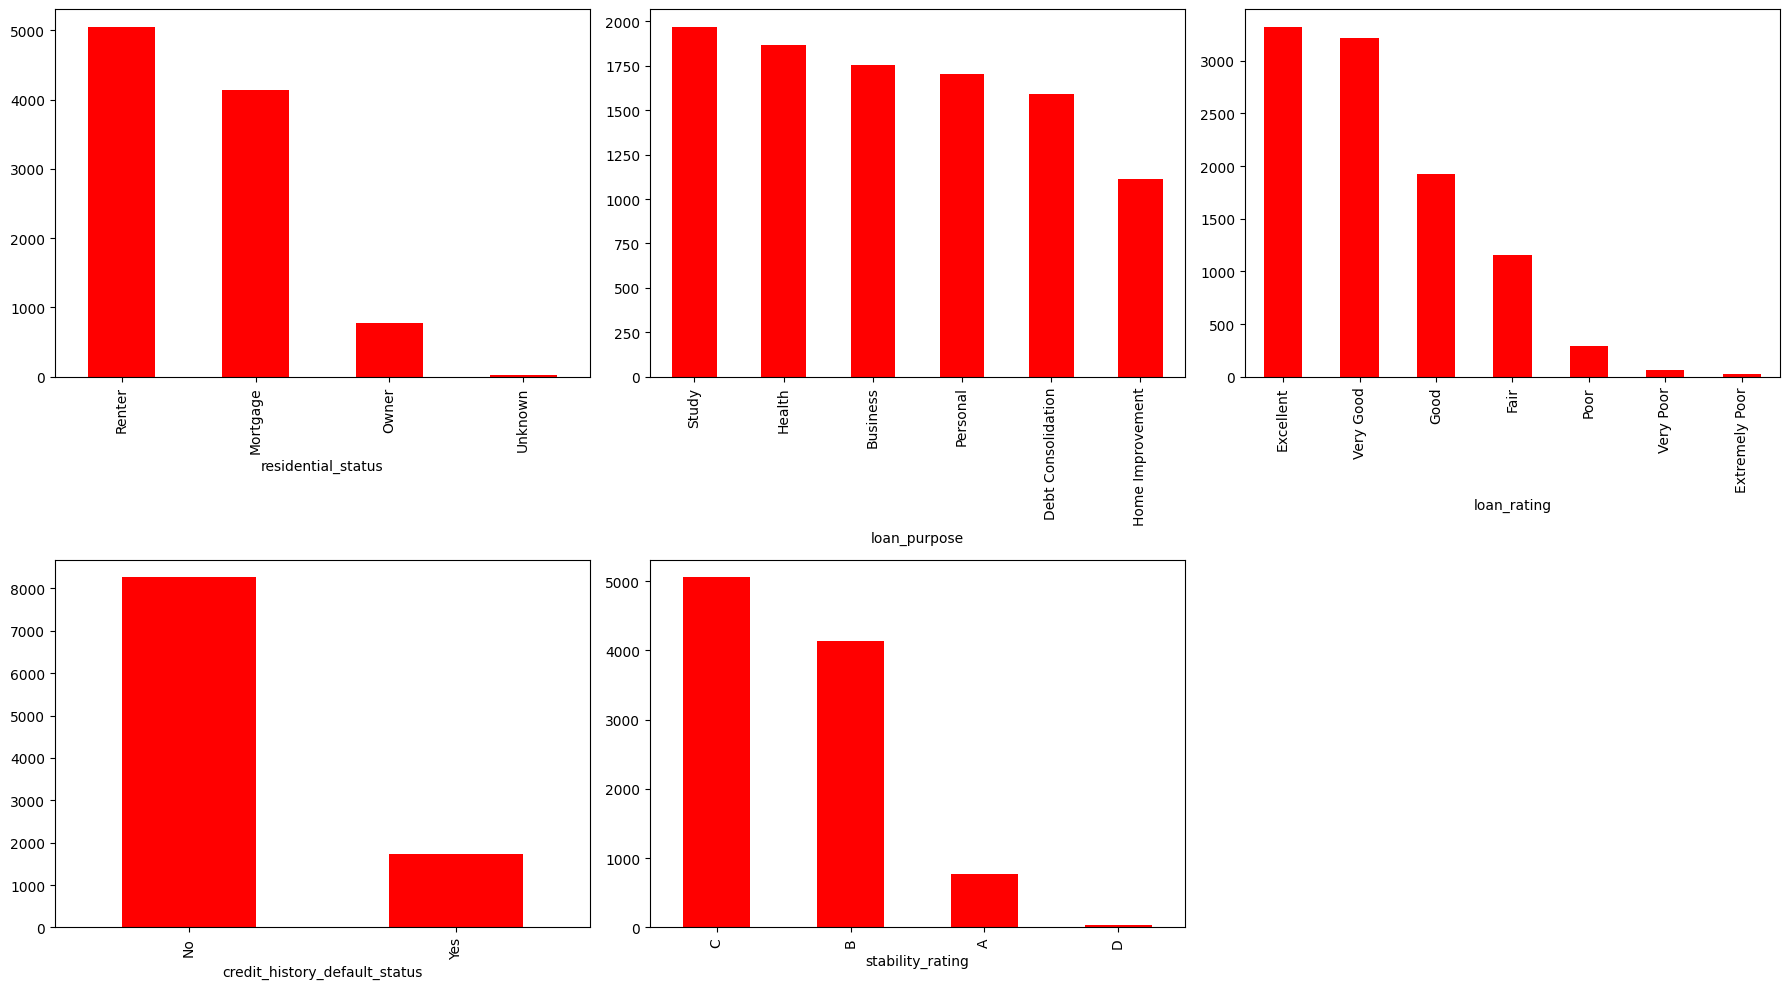

In [1424]:
print_categorical_barplots(cr_df, 'loan_approval_status', 'r')

### 1.2. Dataset-ul "SalaryPrediction_full":

Numarul de atribute numerice continue care nu au valori lipsa:

In [1425]:
sp_df = pd.read_csv(SALARY_PREDICTION_FULL_PATH, na_values=['?'])
sp_df.count(numeric_only=True)

fnl        9999
hpw        9199
gain       9999
edu_int    9999
years      9999
loss       9999
prod       9999
dtype: int64

Valorea medie, deviatia standard a valorilor, valoarea minima, valoarea percentilelor 25%, 50%, 75%, valoarea maxima:

In [1426]:
sp_df.describe()

fnl      hpw      gain  edu_int    years     loss       prod
count    9999.000 9199.000  9999.000 9999.000 9999.000 9999.000   9999.000
mean   190352.902   40.416   979.853   14.262   38.647   84.111   2014.928
std    106070.863   12.517  7003.795   24.771   13.745  394.035  14007.604
min     19214.000    1.000     0.000    1.000   17.000    0.000    -28.000
25%    118282.500   40.000     0.000    9.000   28.000    0.000     42.000
50%    178472.000   40.000     0.000   10.000   37.000    0.000     57.000
75%    237311.000   45.000     0.000   13.000   48.000    0.000     77.000
max   1455435.000   99.000 99999.000  206.000   90.000 3770.000 200125.000

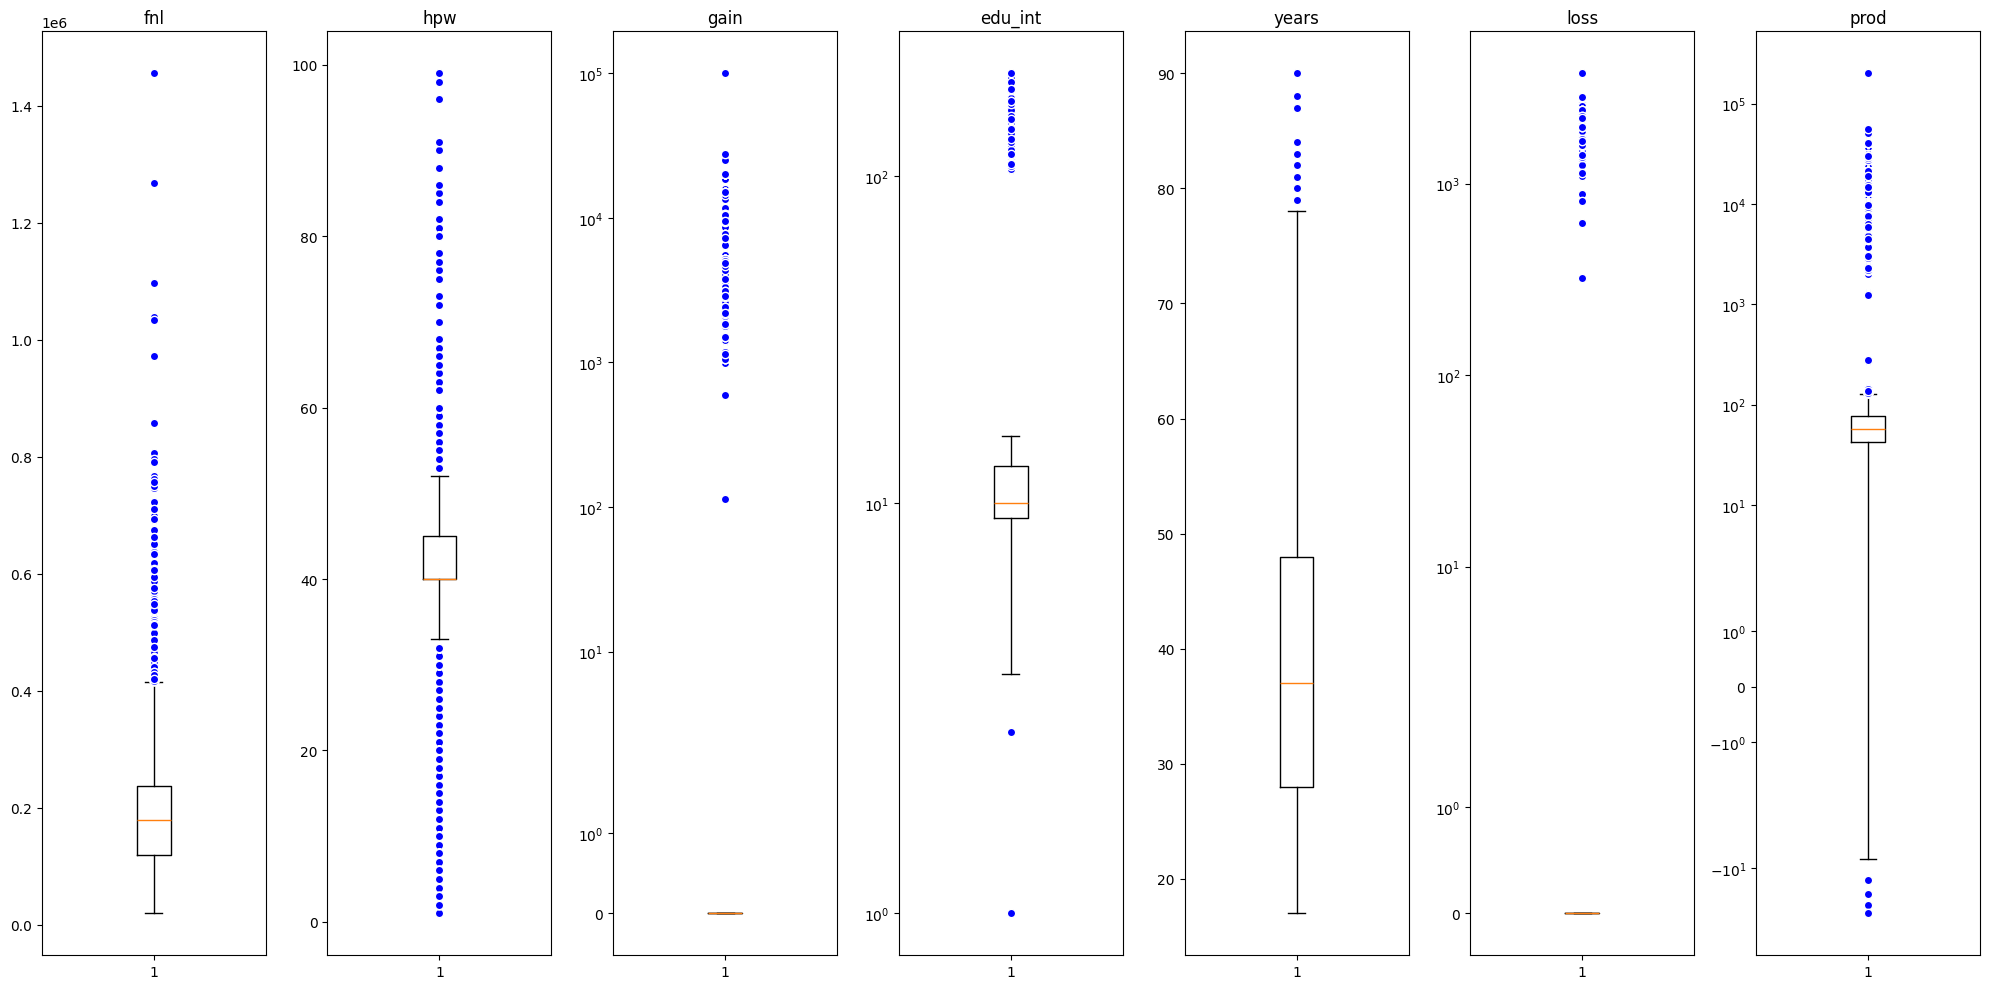

In [1427]:
print_numeric_boxplots(sp_df, blue_circle, [], ['gain', 'loss', 'edu_int', 'prod'])

Numarul de atribute discrete care nu au valori lipsa:

In [1428]:
sp_df.select_dtypes(exclude=['number']).notnull().sum()

relation     9999
country      9841
job          9417
work_type    9419
partner      9999
edu          9999
gender       9199
race         9999
gtype        9999
money        9999
dtype: int64

Numarul de valori unice:

In [1429]:
sp_df.select_dtypes(exclude=['number']).nunique()

relation      6
country      40
job          13
work_type     8
partner       7
edu          16
gender        2
race          5
gtype         2
money         2
dtype: int64

Distributiile atributelor discrete:

In [1430]:
print_categorical_barplots(sp_df, 'money', 'b')

# 2. Analiza echilibrului de clase

### 2.1. Dataset-ul "credit_risk"

Pentru setul de date de antrenare:

In [1431]:
cr_train_df = pd.read_csv(CREDIT_RISK_TRAIN_PATH)
cr_train_df['loan_approval_status'].value_counts().plot(kind='bar', figsize=(8, 4), color='r')

<Axes: xlabel='loan_approval_status'>

Pentru setul de date de test:

<Axes: xlabel='loan_approval_status'>

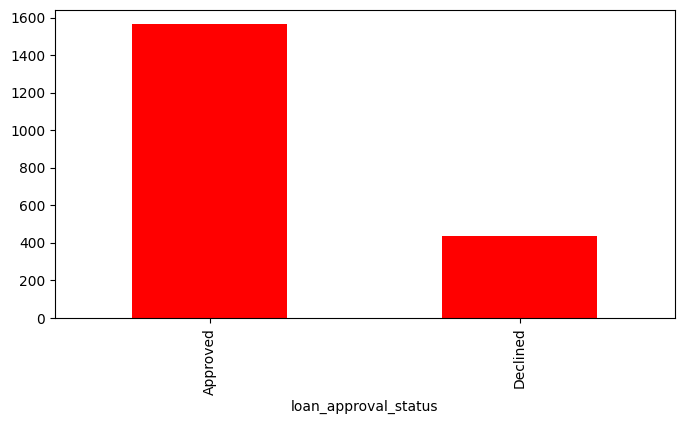

In [1432]:
cr_test_df = pd.read_csv(CREDIT_RISK_TEST_PATH)
cr_test_df['loan_approval_status'].value_counts().plot(kind='bar', figsize=(8, 4), color='r')

### 2.2. Dataset-ul "SalaryPrediction"

Pentru setul de date de antrenare:

<Axes: xlabel='money'>

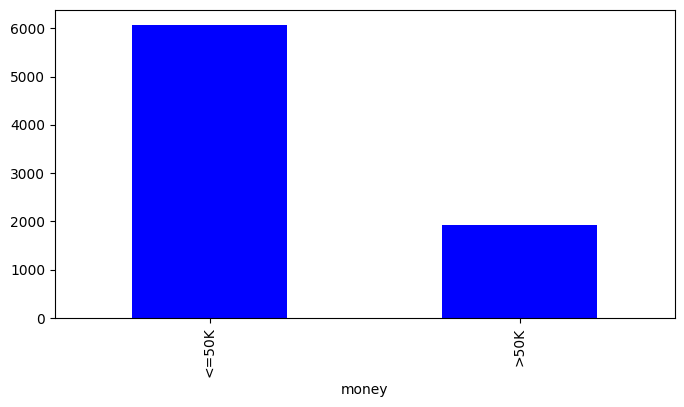

In [1433]:
sp_train_df = pd.read_csv(SALARY_PREDICTION_TRAIN_PATH, na_values=['?'])
sp_train_df['money'].value_counts().plot(kind='bar', figsize=(8, 4), color='b')

Pentru setul de date de test:

<Axes: xlabel='money'>

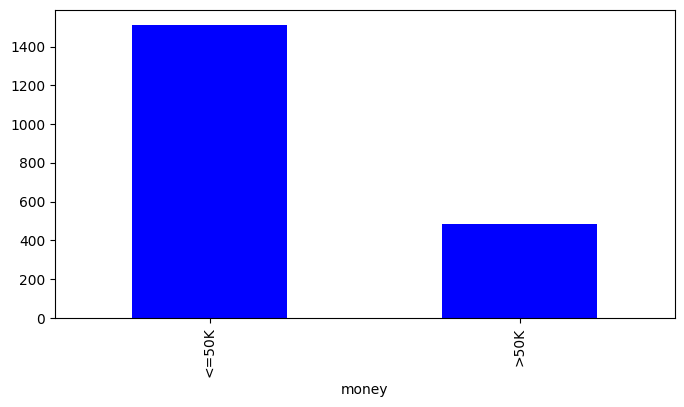

In [1434]:
sp_test_df = pd.read_csv(SALARY_PREDICTION_TEST_PATH, na_values=['?'])
sp_test_df['money'].value_counts().plot(kind='bar', figsize=(8, 4), color='b')

# 3. Analiza corelatiei intre atribute

In [1435]:
def print_numeric_correlation_heatmap(df: pd.DataFrame):
    sns.heatmap(data=df.select_dtypes(include=['number']).corr(method='pearson'), annot=True, fmt='.3f')
    plt.rcParams['figure.figsize'] = [20, 7]


def print_categorical_correlation_heatmap(df: pd.DataFrame):
    categorical_columns = df.select_dtypes(exclude=['number']).columns

    p_value_matrix = pd.DataFrame(np.ones((len(categorical_columns), len(categorical_columns))),
                                index=categorical_columns, columns=categorical_columns)

    for col1 in categorical_columns:
        for col2 in categorical_columns:
            if col1 != col2:

                contingency_table = pd.crosstab(df[col1], df[col2])
                chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)

                p_value_matrix.loc[col1, col2] = p_value
                p_value_matrix.loc[col2, col1] = p_value

    plt.figure(figsize=(20, 7))
    sns.heatmap(p_value_matrix, annot=True, fmt='.3f')

### 3.1. Dataset-ul "credit_risk"

Pentru atributele numerice:

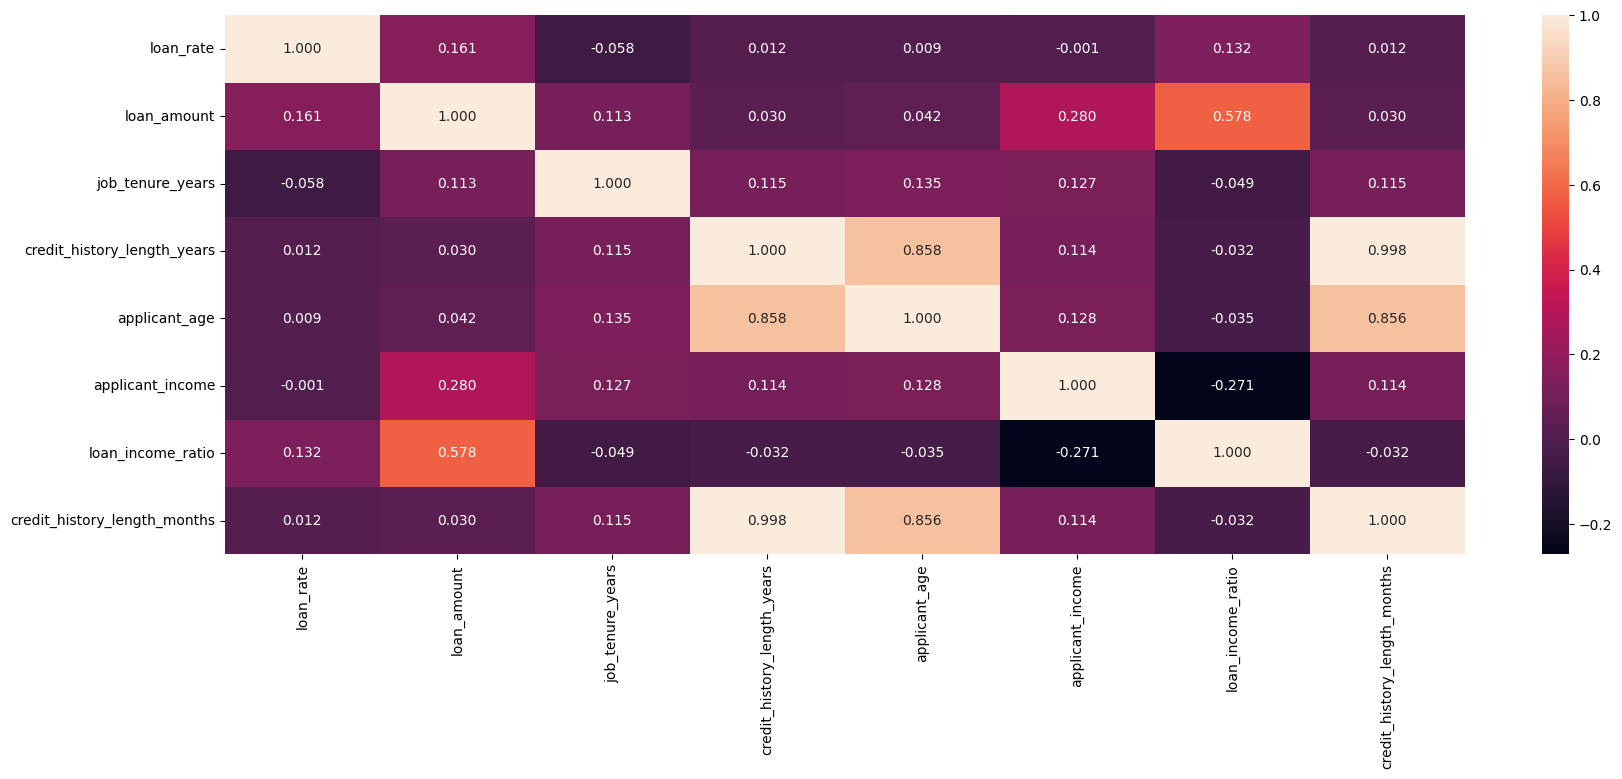

In [1436]:
print_numeric_correlation_heatmap(cr_df)

Pentru atributele categorice:

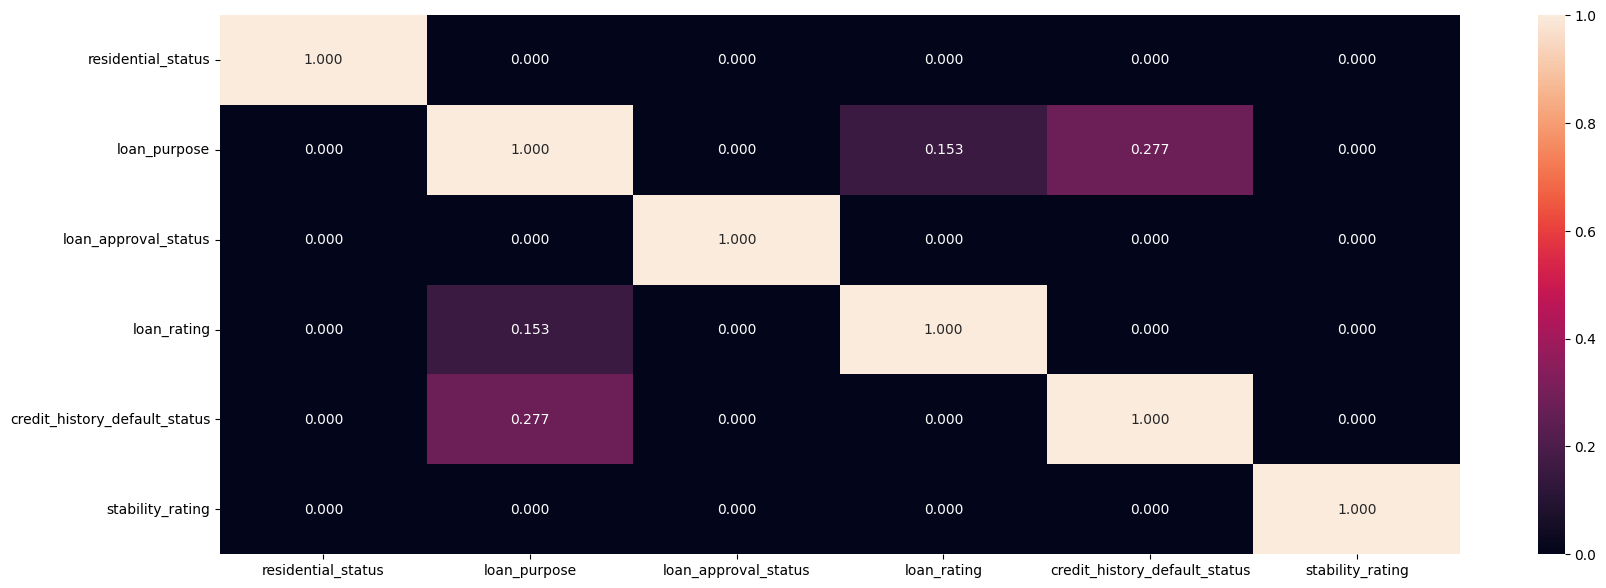

In [1437]:
print_categorical_correlation_heatmap(cr_df)

### 3.2. Dataset-ul "SalaryPrediction"

Pentru atributele numerice:

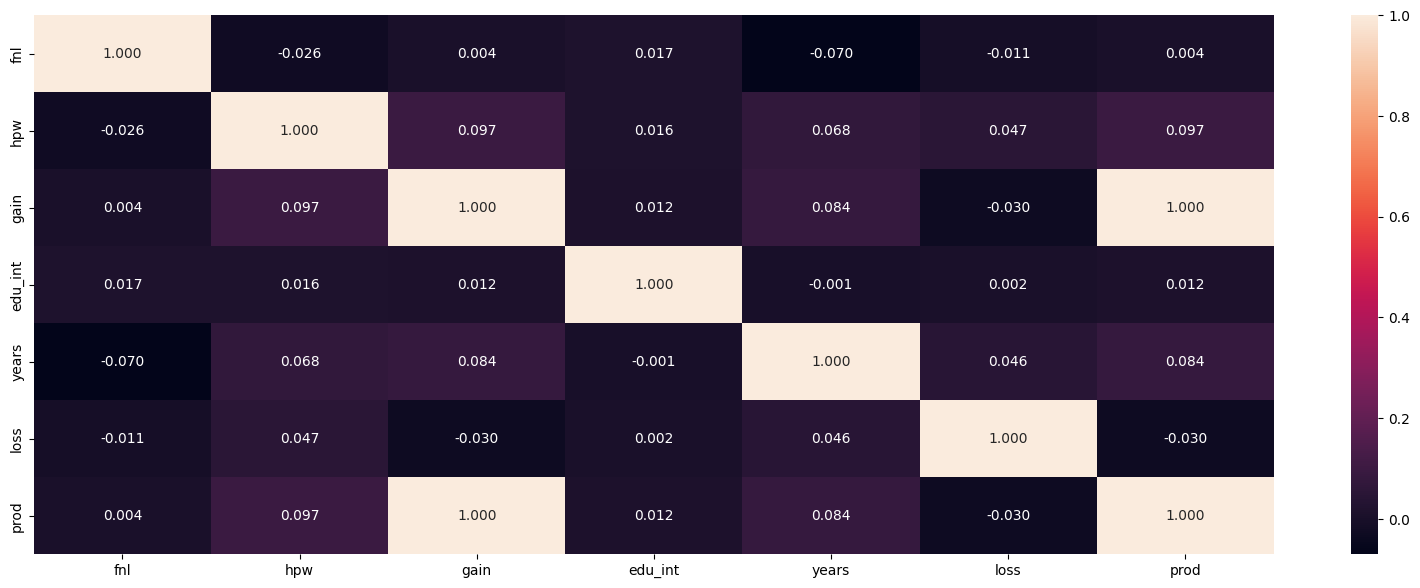

In [1438]:
print_numeric_correlation_heatmap(sp_df)

Pentru atributele categorice:

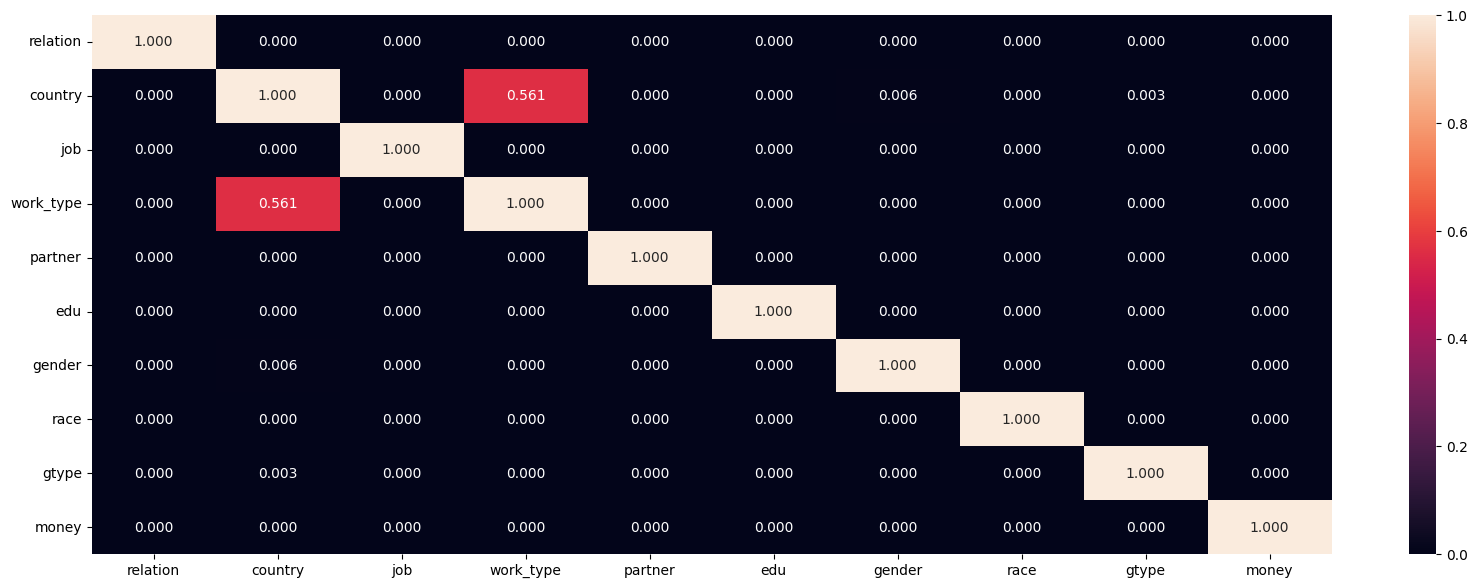

In [1439]:
print_categorical_correlation_heatmap(sp_df)

# 4. Preprocesarea datelor

In [1440]:
def imput_numerical_data(df: pd.DataFrame, imputer) -> pd.DataFrame:
    numerical_columns = df.select_dtypes(include=['number']).columns

    df_imputed = df.copy()
    df_imputed[numerical_columns] = imputer.fit_transform(df[numerical_columns])

    return df_imputed


def imput_categorical_data(df: pd.DataFrame, imputer) -> pd.DataFrame:
    categorical_columns = df.select_dtypes(exclude=['number']).columns

    df_imputed = df.copy()
    df_imputed[categorical_columns] = imputer.fit_transform(df[categorical_columns])

    return df_imputed


def replace_outliers_iqr(df: pd.DataFrame, imputer, threshold=1.5) -> pd.DataFrame:
    numerical_columns = df.select_dtypes(include=['number']).columns

    for column in numerical_columns:
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        iqr = q3 - q1

        outliers = (df[column] < q1 - threshold * iqr) | (df[column] > q3 + threshold * iqr)
        df.loc[outliers, column] = np.nan
    
    imputed_values = imputer.fit_transform(df[numerical_columns])
    df[numerical_columns] = imputed_values

    return df


def scale_numerical_data(df: pd.DataFrame, scaler) -> pd.DataFrame:
    numerical_columns = df.select_dtypes(include=['number']).columns
    scaler = scaler.fit(df[numerical_columns])
    scaled_values = scaler.transform(df[numerical_columns])

    scaled_df = df.copy()
    scaled_df[numerical_columns] = pd.DataFrame(scaled_values, columns=numerical_columns)

    return scaled_df


### 4.1. Dataset-ul "credit_risk"

Imputarea datelor lipsa:

In [1441]:
mean_imputer = SimpleImputer(missing_values=np.nan, strategy='median')
cr_train_df = imput_numerical_data(cr_train_df, mean_imputer)
cr_test_df = imput_numerical_data(cr_test_df, mean_imputer)

most_frequent_imputer = SimpleImputer(strategy='most_frequent')
cr_train_df = imput_categorical_data(cr_train_df, most_frequent_imputer)
cr_test_df = imput_categorical_data(cr_test_df, most_frequent_imputer)


Inlocuirea valorilor extreme:

In [1442]:
iterative_imputer = IterativeImputer(max_iter=10, random_state=0)
cr_train_df = replace_outliers_iqr(cr_train_df, iterative_imputer)
cr_test_df = replace_outliers_iqr(cr_test_df, iterative_imputer)

Standardizarea valorilor atributelor numerice:

In [1443]:
standard_scaler = preprocessing.StandardScaler()
cr_train_df = scale_numerical_data(cr_train_df, standard_scaler)
cr_test_df = scale_numerical_data(cr_test_df, standard_scaler)

Vizualizarea rezultatelor:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   residential_status             10000 non-null  object 
 1   loan_rate                      10000 non-null  float64
 2   loan_amount                    10000 non-null  float64
 3   loan_purpose                   10000 non-null  object 
 4   job_tenure_years               10000 non-null  float64
 5   credit_history_length_years    10000 non-null  float64
 6   applicant_age                  10000 non-null  float64
 7   applicant_income               10000 non-null  float64
 8   loan_rating                    10000 non-null  object 
 9   credit_history_default_status  10000 non-null  object 
 10  loan_income_ratio              10000 non-null  float64
 11  stability_rating               10000 non-null  object 
 12  credit_history_length_months   10000 non-null  

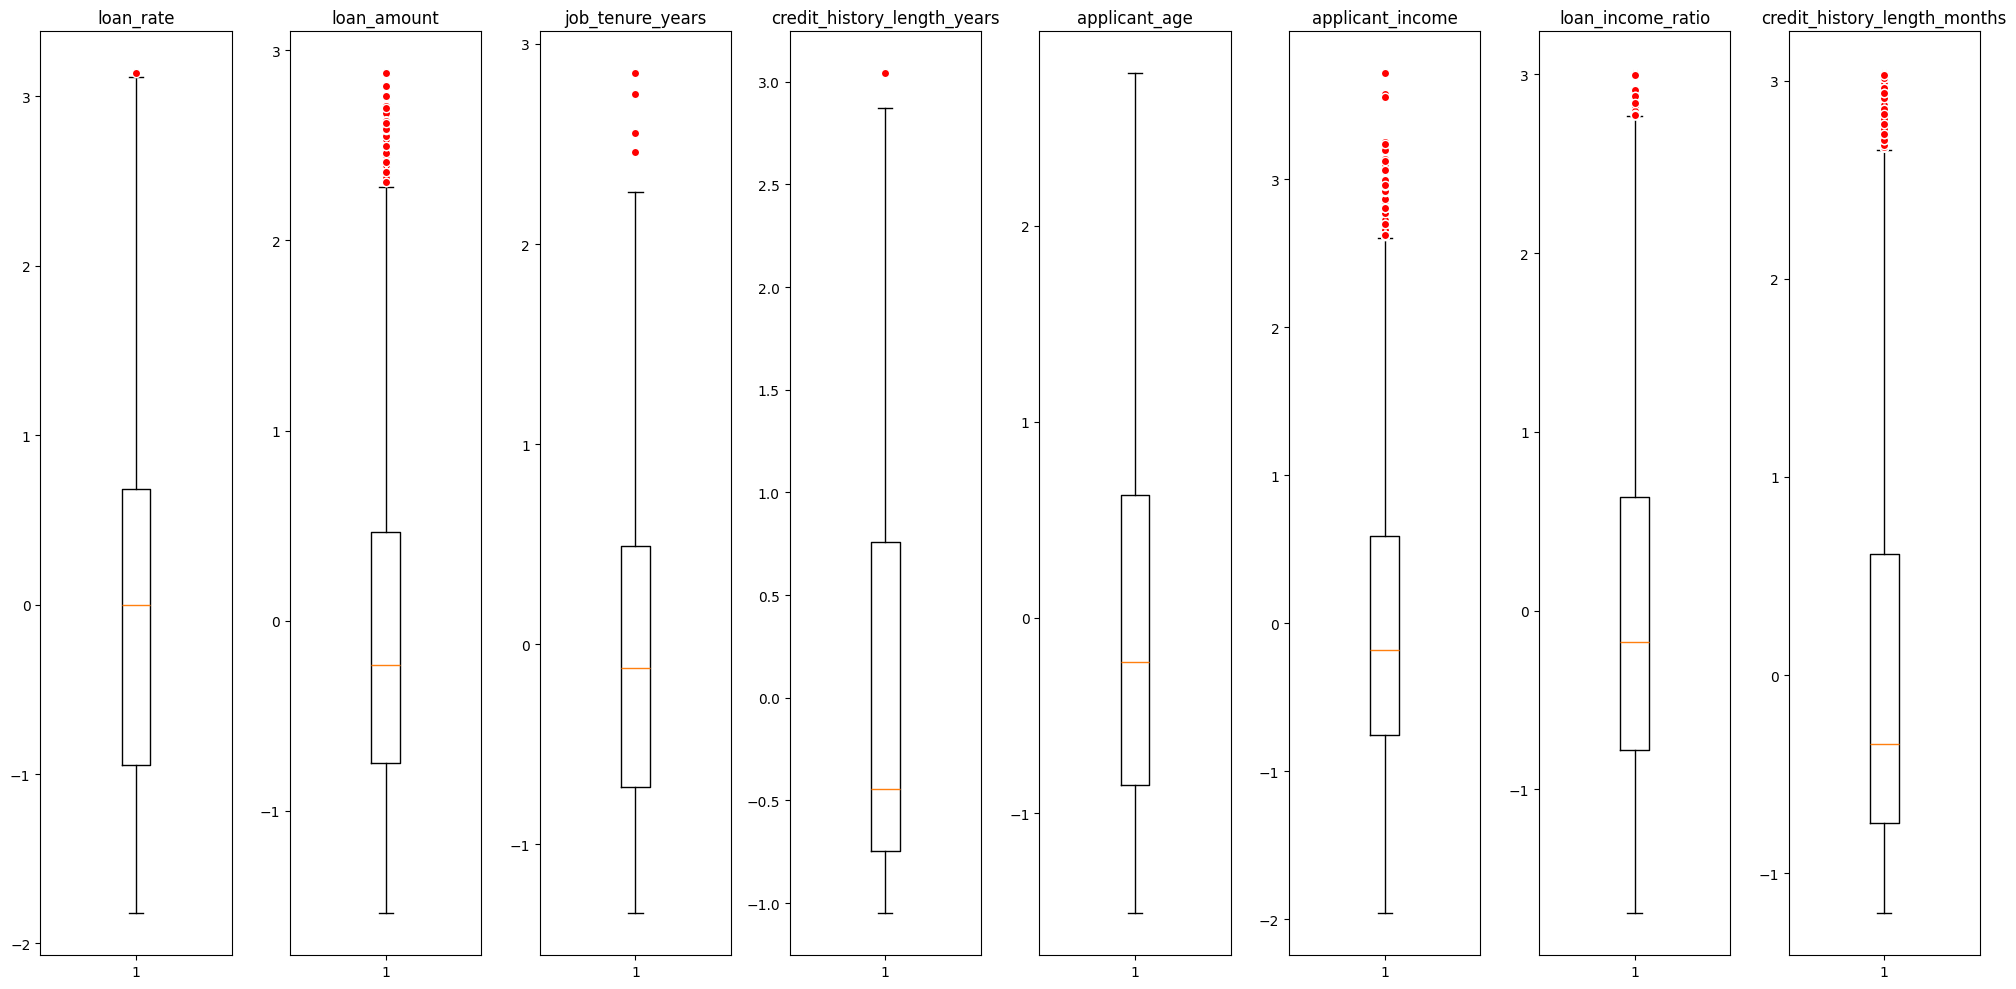

In [1444]:
cr_df = pd.concat([cr_train_df, cr_test_df], axis=0, ignore_index=True)
cr_df.info()
print_numeric_boxplots(cr_df, red_circle)

### 4.2. Dataset-ul "SalaryPrediction"

Imputarea datelor lipsa:

In [1445]:
mean_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
sp_train_df = imput_numerical_data(sp_train_df, mean_imputer)
sp_test_df = imput_numerical_data(sp_test_df, mean_imputer)

most_frequent_imputer = SimpleImputer(strategy='most_frequent')
sp_train_df = imput_categorical_data(sp_train_df, most_frequent_imputer)
sp_test_df = imput_categorical_data(sp_test_df, most_frequent_imputer)

Inlocuirea valorilor extreme:

In [1446]:
iterative_imputer = IterativeImputer(max_iter=10, random_state=0)
sp_train_df = replace_outliers_iqr(sp_train_df, iterative_imputer)
sp_test_df = replace_outliers_iqr(sp_test_df, iterative_imputer)

Standardizarea valorilor atributelor numerice:

In [1447]:
standard_scaler = preprocessing.StandardScaler()
sp_train_df = scale_numerical_data(sp_train_df, standard_scaler)
sp_test_df = scale_numerical_data(sp_test_df, standard_scaler)

Vizualizarea rezultatelor:

In [1448]:
sp_df = pd.concat([sp_train_df, sp_test_df], axis=0, ignore_index=True)
sp_df.info()
print_numeric_boxplots(sp_df, blue_circle)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   fnl        9999 non-null   float64
 1   hpw        9999 non-null   float64
 2   relation   9999 non-null   object 
 3   gain       9999 non-null   float64
 4   country    9999 non-null   object 
 5   job        9999 non-null   object 
 6   edu_int    9999 non-null   float64
 7   years      9999 non-null   float64
 8   loss       9999 non-null   float64
 9   work_type  9999 non-null   object 
 10  partner    9999 non-null   object 
 11  edu        9999 non-null   object 
 12  gender     9999 non-null   object 
 13  race       9999 non-null   object 
 14  prod       9999 non-null   float64
 15  gtype      9999 non-null   object 
 16  money      9999 non-null   object 
dtypes: float64(7), object(10)
memory usage: 1.3+ MB


# 5. Algoritmi de invatare automata

In [1449]:
def split_features(train_df: pd.DataFrame, test_df: pd.DataFrame, target_attribute: str):
    X_train = train_df.drop(columns=[target_attribute])
    y_train = train_df[target_attribute]

    X_test = test_df.drop(columns=[target_attribute])
    y_test = test_df[target_attribute]

    return X_train, y_train, X_test, y_test


def encode_categorical_features(X_train: pd.DataFrame, X_test: pd.DataFrame, encoder):
    categorical_columns = X_train.select_dtypes(exclude=['number']).columns
    X_train_encoded = encoder.fit_transform(X_train[categorical_columns])
    X_test_encoded = encoder.transform(X_test[categorical_columns])

    return X_train_encoded, X_test_encoded


def print_metrics(y_test: pd.Series, y_pred: pd.Series):
    print(classification_report(y_test, y_pred, zero_division=0))
    plt.figure(figsize=(8, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')

In [1450]:
cr_X_train, cr_y_train, cr_X_test, cr_y_test = split_features(cr_train_df, cr_test_df, 'loan_approval_status')

categorical_columns = cr_X_train.select_dtypes(exclude=['number']).columns
cr_X_train[categorical_columns], cr_X_test[categorical_columns] = encode_categorical_features(cr_X_train, cr_X_test, OrdinalEncoder())

In [1451]:
sp_X_train, sp_y_train, sp_X_test, sp_y_test = split_features(sp_train_df, sp_test_df, 'money')

categorical_columns = sp_X_train.select_dtypes(exclude=['number']).columns

ordinal_encoder = OrdinalEncoder()
sp_X_train[categorical_columns] = ordinal_encoder.fit_transform(sp_X_train[categorical_columns])
sp_X_test[categorical_columns] = ordinal_encoder.fit_transform(sp_X_test[categorical_columns])

### 5.1. Arbori de decizie

#### 5.1.1. Folosind biblioteca scikit-learn

Pentru dataset-ul "credit_risk":

              precision    recall  f1-score   support

    Approved       0.91      0.97      0.94      1564
    Declined       0.84      0.66      0.74       436

    accuracy                           0.90      2000
   macro avg       0.88      0.81      0.84      2000
weighted avg       0.90      0.90      0.89      2000



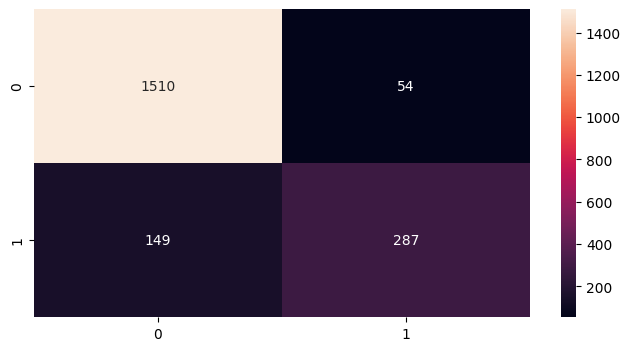

In [1452]:
cr_dtc = DecisionTreeClassifier(
    max_depth=100,
    min_samples_leaf=20,
    criterion='entropy',
    random_state=0,
    ccp_alpha=0.0001)

cr_dtc.fit(cr_X_train, cr_y_train)
cr_y_pred = cr_dtc.predict(cr_X_test)

print_metrics(cr_y_test, cr_y_pred)

Pentru dataset-ul "SalaryPrediction":

In [1453]:
sp_dtc = DecisionTreeClassifier(
    max_depth=40,
    min_samples_leaf=20,
    criterion='entropy',
    random_state=0,
    ccp_alpha=0.0001,
    class_weight={'>50K': 0.6, '<=50K': 0.4})

sp_dtc.fit(sp_X_train, sp_y_train)
sp_y_pred = sp_dtc.predict(sp_X_test)

print_metrics(sp_y_test, sp_y_pred)

              precision    recall  f1-score   support

       <=50K       0.87      0.88      0.88      1513
        >50K       0.62      0.58      0.60       487

    accuracy                           0.81      2000
   macro avg       0.74      0.73      0.74      2000
weighted avg       0.81      0.81      0.81      2000



#### 5.1.2. Implementare bazata pe codul din laborator

In [1454]:
class DecisionTreeNode:   
    def __init__(self, 
                 feature = None, 
                 children = None, 
                 label = None):
       
        self.split_feature = feature 
        self.children = children if (children is not None and feature is not None) else {}
        self.label = label
        self.depth = 1
        self.score = 0
        self.num_samples = 0
    
class DecisionTree:
    def __init__(self,
                 max_depth: int = np.inf,
                 min_samples_per_node: int = 1):
        
        self._root: DecisionTreeNode | None = None
        self._max_depth: int = max_depth
        self._min_samples_per_node: int = min_samples_per_node
        
        
    @staticmethod
    def most_frequent_class(y: pd.Series) -> str:
        return y.mode()[0]
    
    
    @staticmethod
    def compute_entropy(y: pd.Series) -> float:
        class_counts = y.value_counts(normalize=True)
        entropy = -np.sum(class_counts * np.log2(class_counts))

        return entropy
        
    
    @staticmethod
    def compute_information_gain(X: pd.DataFrame, y: pd.Series, feature: str) -> float:
        initial_entropy = DecisionTree.compute_entropy(y)
        final_entropy = 0

        for value in X[feature].unique():
            subset = y[X[feature] == value]
            subset_entropy = DecisionTree.compute_entropy(subset)
            subset_weight = sum(X[feature] == value) / len(X)

            final_entropy += subset_entropy * subset_weight
        
        gain = initial_entropy - final_entropy

        return gain    
    
    def _select_best_split_feature(self, X: pd.DataFrame, y: pd.Series, attribute_list: list[str]) -> str:
        gains = {feature: DecisionTree.compute_information_gain(X, y, feature) for feature in attribute_list}
        return max(gains, key=gains.get) if gains else None
    
    
    def _generate_tree(self, parent_node: DecisionTreeNode | None, X: pd.DataFrame, y: pd.Series, feature_list: list[str], select_feature_func):
        feature_list = deepcopy(feature_list)
        
        node = DecisionTreeNode()
        node.depth = parent_node.depth + 1 if parent_node is not None else 0
        node.score = DecisionTree.compute_entropy(y)  
        node.num_samples = len(y)
        node.label = DecisionTree.most_frequent_class(y)

        if not feature_list or node.depth == self._max_depth or node.num_samples < self._min_samples_per_node or y.nunique() == 1:
            return node

        split_feature = select_feature_func(X, y, feature_list)
        feature_list.remove(split_feature)
        node.split_feature = split_feature

        for value in X[split_feature].unique():
            subset_X = X[X[split_feature] == value]
            subset_y = y[X[split_feature] == value]
            node.children[value] = self._generate_tree(node, subset_X, subset_y, feature_list, select_feature_func)
        
        return node
    
        
    def fit(self, X: pd.DataFrame, y: pd.Series):
        select_feature_func = self._select_best_split_feature
        
        self._root = self._generate_tree(parent_node=None,
                                         X=X,
                                         y=y,
                                         feature_list=X.columns.tolist(),
                                         select_feature_func=select_feature_func)
        
    def _predict_once(self, x: pd.Series) -> str:
        node = self._root
        
        while node.split_feature is not None:
            if node.split_feature in x and x[node.split_feature] in node.children:
                node = node.children[x[node.split_feature]]
            else:
                break
        return node.label
        
    def predict(self, X: pd.DataFrame) -> np.ndarray:
        return np.array([self._predict_once(x) for _, x in X.iterrows()])
    
    def get_depth(self):
        def _get_depth(node: DecisionTreeNode) -> int:
            if node is None:
                return 0
            return max([_get_depth(child) for child in node.children.values()], default=0) + 1
        
        return _get_depth(self._root)
    
    def get_number_of_nodes(self):
        def _get_number_of_nodes(node: DecisionTreeNode) -> int:
            if node is None:
                return 0
            return sum([_get_number_of_nodes(child) for child in node.children.values()], 0) + 1
        
        return _get_number_of_nodes(self._root)
    
    def get_tree_graph(self):
        return self._root.get_tree_graph()
    
    def display(self):
        return self._root.display()

Pentru dataset-ul "credit_risk":

              precision    recall  f1-score   support

    Approved       0.78      1.00      0.88      1564
    Declined       0.00      0.00      0.00       436

    accuracy                           0.78      2000
   macro avg       0.39      0.50      0.44      2000
weighted avg       0.61      0.78      0.69      2000



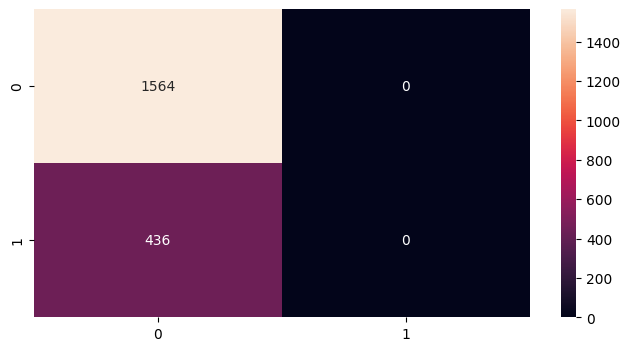

In [1455]:
cr_id3_dtc = DecisionTree(max_depth=100, min_samples_per_node=40)

cr_id3_dtc.fit(cr_X_train, cr_y_train)
cr_id3_y_pred = cr_id3_dtc.predict(cr_X_test)

print_metrics(cr_y_test, cr_id3_y_pred)

.....

Pentru dataset-ul "SalaryPrediction":

              precision    recall  f1-score   support

       <=50K       0.76      1.00      0.86      1513
        >50K       0.00      0.00      0.00       487

    accuracy                           0.76      2000
   macro avg       0.38      0.50      0.43      2000
weighted avg       0.57      0.76      0.65      2000



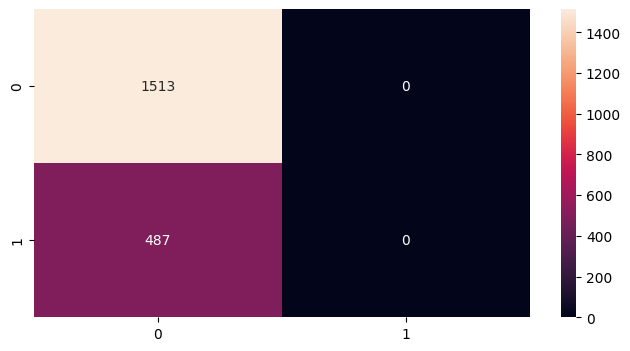

In [1456]:
sp_id3_dtc = DecisionTree(max_depth=100, min_samples_per_node=60)

sp_id3_dtc.fit(sp_X_train, sp_y_train)
sp_id3_y_pred = sp_id3_dtc.predict(sp_X_test)

print_metrics(sp_y_test, sp_id3_y_pred)

### 5.2. Multi-Layered Perceptron

#### 5.2.1. Folosind biblioteca scikit-learn

Pentru dataset-ul "credit_risk":

              precision    recall  f1-score   support

    Approved       0.89      0.98      0.93      1564
    Declined       0.89      0.55      0.68       436

    accuracy                           0.89      2000
   macro avg       0.89      0.77      0.81      2000
weighted avg       0.89      0.89      0.88      2000



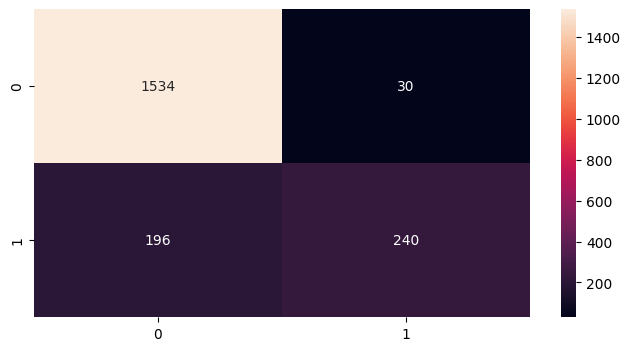

In [1457]:
cr_mlp = MLPClassifier(
    hidden_layer_sizes=(100, 150),
    activation='relu',
    solver='adam',
    alpha=0.0008,
    learning_rate_init=0.04,
    max_iter=5000,
    batch_size=100,
    early_stopping=True,
    random_state=0
)

cr_mlp.fit(cr_X_train, cr_y_train)
cr_y_pred = cr_mlp.predict(cr_X_test)

print_metrics(cr_y_test, cr_y_pred)

Pentru dataset-ul "SalaryPrediction":

              precision    recall  f1-score   support

       <=50K       0.87      0.90      0.89      1513
        >50K       0.66      0.59      0.63       487

    accuracy                           0.83      2000
   macro avg       0.77      0.75      0.76      2000
weighted avg       0.82      0.83      0.82      2000



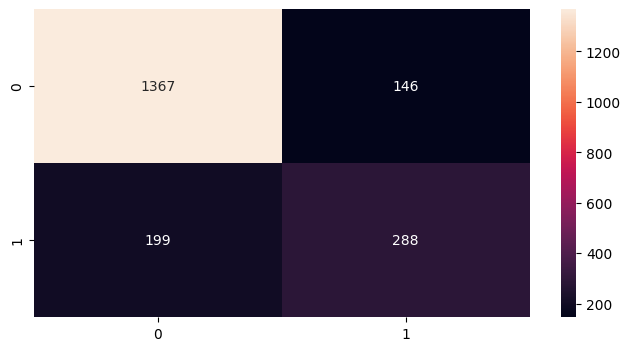

In [1458]:
sp_mlp = MLPClassifier(
    hidden_layer_sizes=(784, 128),
    activation='relu',
    solver='adam',
    alpha=0.0004,
    learning_rate_init=0.005,
    max_iter=20,
    batch_size=128,
    early_stopping=True,
    random_state=0
)

sp_mlp.fit(sp_X_train, sp_y_train)
sp_y_pred = sp_mlp.predict(sp_X_test)

print_metrics(sp_y_test, sp_y_pred)


#### 5.2.2. Implementare bazata pe codul din laborator

In [1459]:
class Layer:
    def forward(self, x: np.ndarray) -> np.ndarray:
        raise NotImplementedError
        
    def backward(self, x: np.ndarray, dy: np.ndarray) -> np.ndarray:
        raise NotImplementedError
        
    def update(self, *args, **kwargs):
        pass

class FeedForwardNetwork:
    
    def __init__(self, layers: List[Layer]):
        self.layers = layers
        
    def forward(self, x: np.ndarray, train: bool = True) -> np.ndarray:
        self._inputs = []
        for layer in self.layers:
            if train:
                self._inputs.append(x)
            x = layer.forward(x)
        return x
    
    def backward(self, dy: np.ndarray) -> np.ndarray:
        for input, layer in zip(reversed(self._inputs), reversed(self.layers)):
            dy = layer.backward(input, dy)

        return dy
    
    def update(self, *args, **kwargs):
        for layer in self.layers:
            layer.update(*args, **kwargs)

    def predict(self, x: np.ndarray) -> np.ndarray:
        return self.forward(x, train=False)

class Linear(Layer):
    
    def __init__(self, insize: int, outsize: int) -> None:
        bound = np.sqrt(6. / insize)
        self.weight = np.random.uniform(-bound, bound, (insize, outsize))
        self.bias = np.zeros((outsize,))
        
        self.dweight = np.zeros_like(self.weight)
        self.dbias = np.zeros_like(self.bias)
   
    def forward(self, x: np.ndarray) -> np.ndarray:       
        return np.dot(x, self.weight) + self.bias
    
    def backward(self, x: np.ndarray, dy: np.ndarray) -> np.ndarray:
        self.dweight = np.dot(x.T, dy)
        self.dbias = np.sum(dy, axis=0)
        return np.dot(dy, self.weight.T)
    
    def update(self, lr=0.001):
        self.weight -= lr * self.dweight
        self.bias -= lr * self.dbias
        
class ReLU(Layer):
    
    def __init__(self) -> None:
        pass
    
    def forward(self, x: np.ndarray) -> np.ndarray:
        return np.maximum(x, 0)
    
    def backward(self, x: np.ndarray, dy: np.ndarray) -> np.ndarray:
        return (x > 0) * dy
    
class CrossEntropy:
    
    def __init__(self):
        pass
    
    def softmax(self, x):
        exps = np.exp(x)
        return exps / np.sum(exps,axis = 1).reshape(-1,1)

    def forward(self, y: np.ndarray, t: np.ndarray) -> float:
        dy = self.softmax(y)
        dy = -np.log(dy[np.arange(len(dy)), t])
        return np.mean(dy)
    
    def backward(self, y: np.ndarray, t: np.ndarray) -> np.ndarray:
        dy = self.softmax(y)
        delta = np.zeros_like(dy)
        delta[np.arange(len(dy)), t] = 1
        return (dy - delta) / len(dy)


def train(network: FeedForwardNetwork, X_train: np.ndarray, y_train: np.array, epochs=20, batch_size=128, learning_rate=0.005) -> FeedForwardNetwork:
    loss_function = CrossEntropy()

    for _ in range(epochs):
        for idx in range(0, len(X_train), batch_size):
            x = X_train[idx:idx + batch_size]
            t = y_train[idx:idx + batch_size]

            # Forward pass
            y = network.forward(x)

            # Backward pass
            dy = loss_function.backward(y, t)
            network.backward(dy)

            # Update weights
            network.update(lr=learning_rate)

    return network



def softmax2(x: np.ndarray) -> np.ndarray:
    exps = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exps / np.sum(exps, axis=1, keepdims=True)

def predict(network: FeedForwardNetwork, X: np.ndarray) -> np.ndarray:
    logits = network.forward(X, train=False)
    probabilities = softmax2(logits)
    predictions = np.argmax(probabilities, axis=1)
    return predictions

Pentru dataset-ul "credit_risk":

              precision    recall  f1-score   support

    Approved       0.88      0.95      0.91      1564
    Declined       0.75      0.54      0.62       436

    accuracy                           0.86      2000
   macro avg       0.81      0.74      0.77      2000
weighted avg       0.85      0.86      0.85      2000



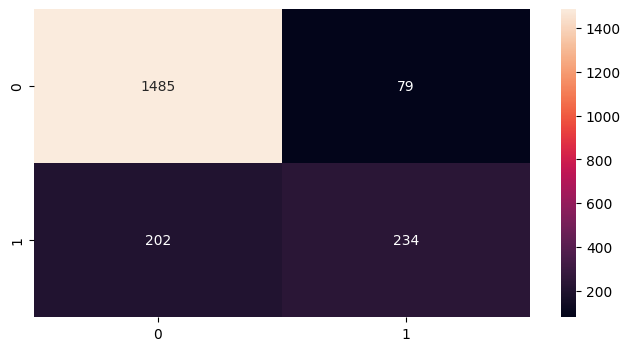

In [1460]:
layers = [
    Linear(cr_X_train.shape[1], 100),
]

for _ in range(10):
    layers.append(ReLU())
    layers.append(Linear(100, 100))

layers.append(ReLU())
layers.append(Linear(100, 2))
    
label_encoder = preprocessing.LabelEncoder()
cr_y_train = label_encoder.fit_transform(cr_y_train)
cr_y_test = label_encoder.transform(cr_y_test)

network = FeedForwardNetwork(layers)
trained_network = train(network, cr_X_train, cr_y_train)

cr_y_pred = predict(trained_network, cr_X_test)
cr_y_pred = label_encoder.inverse_transform(cr_y_pred)
cr_y_test = label_encoder.inverse_transform(cr_y_test)

print_metrics(cr_y_test, cr_y_pred)


Pentru dataset-ul "SalaryPrediction":

              precision    recall  f1-score   support

       <=50K       0.85      0.90      0.87      1513
        >50K       0.61      0.51      0.56       487

    accuracy                           0.80      2000
   macro avg       0.73      0.70      0.71      2000
weighted avg       0.79      0.80      0.80      2000



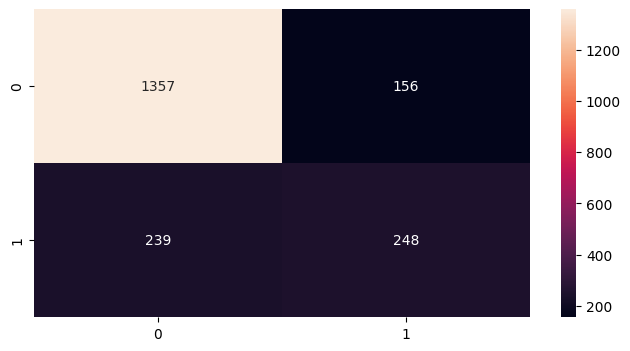

In [1461]:
layers = [
    Linear(sp_X_train.shape[1], 100),
]

for _ in range(10):
    layers.append(ReLU())
    layers.append(Linear(100, 100))

layers.append(ReLU())
layers.append(Linear(100, 2))
    
label_encoder = preprocessing.LabelEncoder()
sp_y_train = label_encoder.fit_transform(sp_y_train)
sp_y_test = label_encoder.transform(sp_y_test)

network = FeedForwardNetwork(layers)
trained_network = train(network, sp_X_train, sp_y_train)

sp_y_pred = predict(trained_network, sp_X_test)
sp_y_pred = label_encoder.inverse_transform(sp_y_pred)
sp_y_test = label_encoder.inverse_transform(sp_y_test)

print_metrics(sp_y_test, sp_y_pred)
